## Accounting uncertainty using additional jitter term (Step1)

* created: 11/11
cloned from tutorial_part6_quad_jitter_simultaneous.ipynb

This is a (test) simultaneous model with jitter term in the uncertainty.

$$
\sigma = \sqrt{\sigma^2_{obs}+\sigma^2_{jitter}}
$$

2 step analysis:

STEP 1:
* model each band separately but single prior on rho_star 
(propagating on k and other params); monte carlo simulation of error bars
* no prior on rho_star yet


STEP 2:
simultaneous multi-band
* take the MAP of sys and correct lc
* fix sys coeffs in step 2 while transit params are shared
* check uncertainties of transit params from results of step 1 are 1-sigma with that of method2

In [1]:
#check python version
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize = 18

## import data

In [5]:
data_dir='data/'

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='13'#3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
sigma=5

for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    #manipulate columns
    cols = df.columns.tolist()
    cols.remove('#')
    cols.insert(-1,' ')
    df.columns = cols
    try:
        df=df.drop(['Unnamed: 21','frame', ' '],axis=1)
    except:
        pass
    df=df.set_index('BJD(TDB)-2450000')
    #df['BJD(TDB)'] = df['BJD(TDB)-2450000'].apply(lambda x: x + 2450000)
    #df=df.set_index('BJD(TDB)')
    #remove outliers
    df=df[np.abs(df-df.mean())<=(sigma*df.std())]
    data[b]=df.dropna()

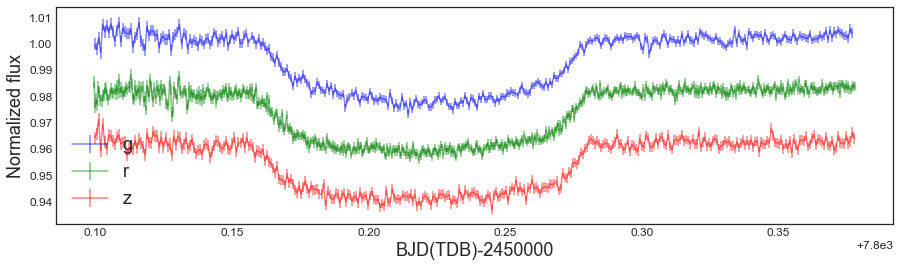

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    #print(len(df))
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

## setting-up the transit model 

See part2.

In [7]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    assert len(parameters) == 6
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [8]:
import numpy as np
from astropy import units as u

_tc  = 2455696.93695
_P   = 4.301219
_inc = np.deg2rad(89.10)
_t14  = 0.13020
_b    = 0.172
_k    = np.sqrt(0.01804) #± 0.np.sqrt(00027)
Rp = 1.24 #Rjup
Rs = 0.949*u.Rsun.to(u.Rjup) #Rsol to Rjup
k_ = Rp/Rs

_a_s = 11.52
#a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)

tc_0      = 7.8e3+0.22 #-2450000

In [9]:
import limbdark as ld

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

ldc_list     = []
ldc_err_list = []
ldp          = []

#for each band
for i in 'g*,r*,z*'.split(','):
    ldc = ld.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    ldp.append(ldc)
    
    #save in list
    #u1,u2
    ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
    #uncertainties
    ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Transit model parameter estimation: Frequentist approach

### Maximum Likelihood Estimation (MLE)

See part3

In [10]:
import scipy.optimize as op

def obj(theta, p, t, f, err, qerr=False):
    '''
    objective function: chi-square
    '''
    
    if qerr:
        assert len(theta) == 7
        lsjit=theta[6] #log sigma
        sjit = np.exp(lsjit)
        quad_err = np.sqrt(sjit**2+err**2)
        
        m = transit_model_q(theta[:6], p, t)
        return np.sum(((m-f)/quad_err)**2)
    
    else:
        assert len(theta) == 6
        #lsjit=theta[6] #log sigma

        m = transit_model_q(theta[:6], p, t)
        return np.sum(((m-f)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

g-band
rms before: 0.0030
rms after: 0.0025

r-band
rms before: 0.0029
rms after: 0.0023

z-band
rms before: 0.0033
rms after: 0.0026



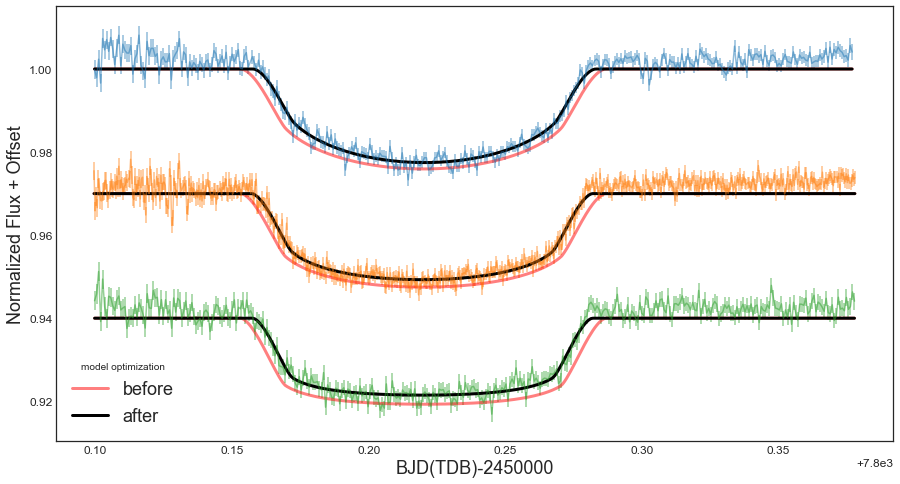

In [11]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot raw data with vertical offset
    offset = n*0.03
    pl.errorbar(time, flux-offset, yerr=err, alpha=0.5) 
    
    #compute q from u found in limbdark
    q1_,q2_ = u_to_q(u[0],u[1])

    #log of sigma jitter
    #lsjit = -2 #np.log(np.std(flux))
    
    #compute flux before optimization
    ##transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b, lsjit]
    transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b]
    
    transit_model_before  = transit_model_q(transit_params[:6], _P, time)
    #rms before
    rms_before = rms(flux,transit_model_before)
    print('rms before: {:.4f}'.format(rms_before))
    
    #optimize parameters
    result = op.minimize(obj, transit_params,
                         args=(_P, time, flux, err), method='nelder-mead')
    
    #compute flux after optimization
    transit_params_after     = np.copy(result.x[:6])
    transit_model_after  = transit_model_q(transit_params_after, _P, time)
    #rms after
    rms_after = rms(flux,transit_model_after)
    print('rms after: {:.4f}\n'.format(rms_after))
    
    #plot transit models
    #before (faint red)
    ax.plot(time, transit_model_before-offset, 'r-', lw=3, alpha=0.5)
    #after (black)
    ax.plot(time, transit_model_after-offset, 'k-', lw=3, alpha=1)
    ax.legend(fontsize=fontsize)
    
    #dict of optimized transit parameters to be used later
    optimized_transit_params[b] = transit_params_after
    n+=1
    
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
ax.set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [12]:
optimized_transit_params

{'g': array([  1.28865834e-01,   6.82600819e-01,   4.94051860e-01,
          7.80022041e+03,   1.22220601e+01,   1.65191953e-01]),
 'r': array([  1.29256326e-01,   5.10718285e-01,   3.47381162e-01,
          7.80021956e+03,   1.22601286e+01,   1.74637700e-01]),
 'z': array([  1.26909619e-01,   3.18040108e-01,   2.18617173e-01,
          7.80021975e+03,   1.22829180e+01,   1.80290322e-01])}

## Systematics Modeling

See part4.

In [13]:
print('no. of data points:')
for b in bands:
    print('{}:\t{}'.format(b, len(data[b]['flux(r=11.0)'])))

no. of data points:
g:	374
r:	703
z:	376


In [14]:
def binning(x,y,bins):
    t=np.linspace(x[0],x[-1], bins)
    y=np.interp(x=t, xp=x, fp=y)
    return t, y

def flux_ratios(x1, y1, x2, y2, bins):
    numerator   = binning(x1,y1,bins)[1] #get y-component only
    denominator = binning(x2,y2,bins)[1]
    return numerator/ denominator

In [15]:
#systematics model
def systematics_model(w, aux_vec, time):
    '''
    systematics model consists of linear combination
    of constant coefficients (computed here) 
    and auxiliary vectors:
    
    color1, color2, dx, err, vert_offset
    
    The functional form of the model is
    s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    '''
    #make sure there are 4 aux. vectors
    assert len(aux_vec) == 4
    assert len(w) == 6
    
    #unpack aux_vec
    color1, color2, dx, err = aux_vec
    #add vertical offset
    vert_offset = np.ones_like(dx)
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    
    #compute systematics model
    sys_model = np.dot(X,w)
        
    return sys_model

In [16]:
def find_2_bands(b):
    '''
    this function return the 2 bands
    other than the given band
    
    e.g. if g, return r & z
    '''
    if b=='g':
        return ['r','z']
    elif b=='r':
        return ['g','z']
    elif b=='z':
        return ['g','r']
    else:
        sys.exit(1)

g-band
rms (resid): 0.0025
rms (resid - systematics model): 0.0015

rms difference: 0.0010

r-band
rms (resid): 0.0023
rms (resid - systematics model): 0.0015

rms difference: 0.0008

z-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0013

rms difference: 0.0013



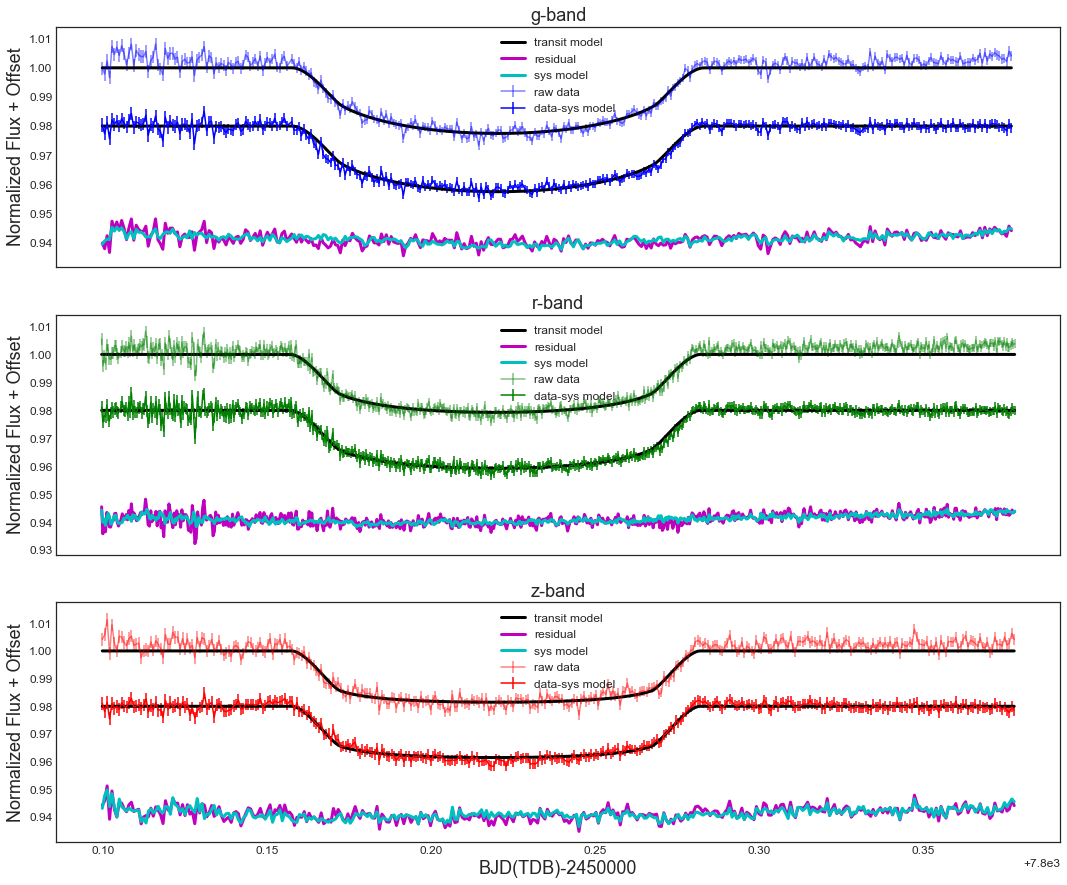

In [17]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

X_list = {}
w_list = {}
aux_vec_list = {}

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    dx   = df['dx(pix)']
    dy   = df['dy(pix)']
    airmass = df['airmass']
    #fwhm    = df['fwhm(pix)']
    #sky     = df['sky(ADU)']
    #peak    = df['peak(ADU)']
    
    
    #plot raw data
    ax[n].errorbar(time, flux, yerr=err, label='raw data', alpha=0.5, color=c) 
    
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params[:6], _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    #plot residual with offset
    resid = flux - transit_model
    ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    #add resid to original dataframe
    data[b]['residual'] = resid
    
    #determine correct band
    b1,b2 = find_2_bands(b)
    
    #compute color
    color1 = flux_ratios(time,flux,data[b1].index,
                       data[b1][fluxcol], 
                       bins=len(df))
    color2 = flux_ratios(time,flux,data[b2].index,
                       data[b2][fluxcol], 
                       bins=len(df))
    #add color to original dataframe
    data[b]['color1'] = color1
    data[b]['color2'] = color2
    
    #add vertical offset
    vert_offset = np.ones_like(dx)
    
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    X_list[b] = X
    
    #compute systematics model
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))
    w_list[b] = w
    
    #6 sys model coefficients
    
    aux_vec = [color1, color2, dx, err]
    aux_vec_list[b] = aux_vec
    
    #evaluate model
    sys_model = systematics_model(w, aux_vec, time)
    
    #compute rms
    rms_before = rms(flux, transit_model)
    rms_after = rms(resid,sys_model)
    print('rms (resid): {:.4f}'.format(rms_before))
    print('rms (resid - systematics model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    #plot flux minus systematics
    ax[n].errorbar(time, flux-sys_model-0.02, yerr=err, 
                   label='data-sys model', alpha=1, color=c) 
    ax[n].plot(time, transit_model-0.02, 'k-', lw=3)#, label='transit model')
    
    #plot systematics model
    ax[n].plot(time, sys_model+0.94, 'c-', lw=3, label='sys model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

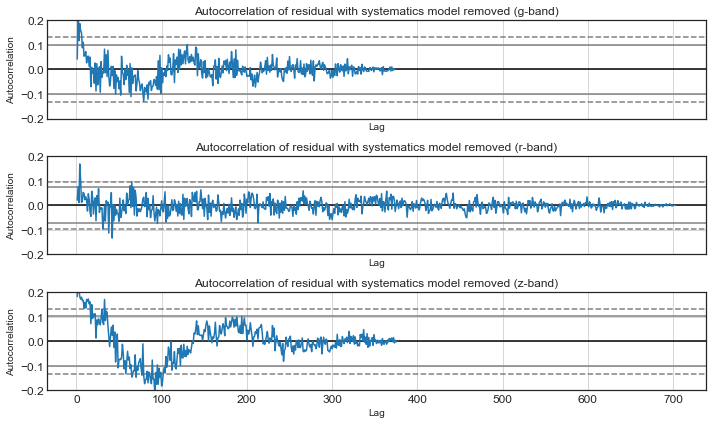

In [18]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    
    #get residual computed earlier    
    resid = data[b]['residual']
    
    #evaluate model
    sys_model = systematics_model(w_list[b], aux_vec_list[b], time)
    
    resid_wo_sys = resid - sys_model
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()

---

## Transit model parameter estimation: Bayesian approach

* Simultaneous modeling (part5)
 * transit model
 * systematics model
* Bayes' theorem (part5)
 * Likelihood
 * Prior
 
* MCMC using `emcee`

### Bayes' Theorem

The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the Bayes' theorem as (c.f. [wiki](https://en.wikipedia.org/wiki/Bayes%27_theorem)):

$$
P(\theta|D) \propto P(\theta) \times P(D|\theta) \\
\rm{Posterior \propto Prior \times Likelihood}
$$
where $P(\theta)$ is the prior, $P(D|\theta)$ is the likelihood for the data.

### Likelihood for transit & systematics parameters

Assuming that the variables in our model are independent, identically distributed ([iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)) random variables, we can expect that the residual (data - transit - systematics model) follows a Gaussian distribution. 

$$
\mathcal{L}(\theta|M) = N(\mu,\sigma) = \frac{1}{\sqrt{2\pi \sigma}} \exp-\frac{(x-\mu)^2}{2\sigma^2}
$$

### $\log$ Likelihood (ll)

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\Big[\log(2\pi) +\log\sigma +\Big(\frac{x-\mu}{\sigma}\Big)^2\Big]
$$

where 
$$
\sigma = \sqrt{\sigma^2_{obs}+\sigma^2_{jitter}}
$$

Now, let's write a function that computes the value above.

In [19]:
def loglike(params_full, p, t, f, err, aux_vec, 
            ret_mod=False, ret_sys=False, ret_full = False, qerr=False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    #color1,color2,dx,err = aux_vec
    assert len(aux_vec) == 4
        
    if qerr==True:
        #log of sigma jitter
        lsjit = params_full[6]
        #sigma_jitter
        sjit = np.exp(lsjit) 

        #final errors
        final_err = np.sqrt(sjit**2+err**2)    
        
        m = transit_model_q(params_full[:7], p, t)
        
        assert len(params_full[7:]) == 6

        s = systematics_model(params_full[7:], aux_vec, t) # #add sys model
    
    else:
        m = transit_model_q(params_full[:6], p, t)
        #color1,color2,dx,err = aux_vec
        assert len(params_full[6:]) == 6

        s = systematics_model(params_full[6:], aux_vec, t) # #add sys model
        final_err = err
        
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    #-0.5*(np.sum((resid)**2 * np.exp(-2*ls) + 2*ls))
    C = np.log(2*np.pi)
    
    return -0.5*(np.sum(np.log(final_err) + C + (resid/final_err)**2))

### negative log likelihood (nll)

Goal:
* Maximize likelihood but `scipy.optimize.minimize` is (only?) available
* Use nll instead! --> minimizing nll == maximizing ll !!!

In [20]:
#negative log-likelihood
nll = lambda *x: -loglike(*x)

## Simultaneous modeling of transit and systematics parameters

--g--
NLL before: -718.1644619637995
NLL after: -737.4003342444432
--r--
NLL before: -1331.4601730059
NLL after: -1348.9346691181618
--z--
NLL before: -752.4928054594134
NLL after: -760.7964051341187


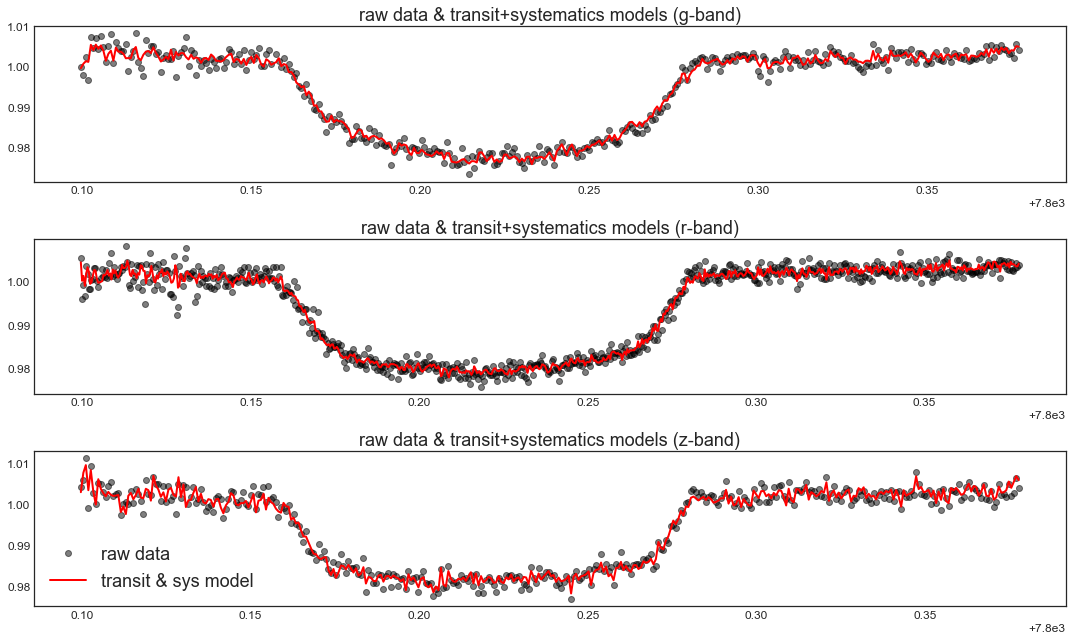

In [21]:
#parameters vector: 6 transit, 4+2 systematics

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

save_model = True
qerr = False

n=0
for b in bands:
    df=data[b]

    flux = df[fluxcol]
    time = df.index

    #sys mod params
    airmass   = df['airmass']
    err       = df['err(r=11.0)']
    dx        = df['dx(pix)']
    #dy        = df['dy(pix)']
    print('--{}--'.format(b))
    
    #transit params computed before (includes lsj)
    transit_params = optimized_transit_params[b]
    
    #weights computed before
    w = w_list[b]
        
    #aux_vec saved before
    aux_vec = aux_vec_list[b]
    
    
    #combine optimized transit params and sys params
    if qerr:
        lsjit = -3 #np.log(np.std(flux))
        full_params = np.concatenate((transit_params, [lsjit], w), axis=0)
        #6+1+6
        assert len(full_params) == 13
    else:
        full_params = np.concatenate((transit_params, w), axis=0)
        assert len(full_params) == 12
    
    #print(len(full_params))
    
    #compute nll
    print ("NLL before: {}".format(nll(full_params, 
                                       _P, 
                                       time, 
                                       flux, 
                                       err, 
                                       aux_vec)))
    #MLE optimization of transit+sys parameters
    result = op.minimize(nll, full_params,    
                         args=(_P, time, flux, err, aux_vec),
                         method='nelder-mead')
    
    #result of optimization
    print ("NLL after: {}".format(nll(result.x,   
                                      _P, 
                                      time, 
                                      flux, 
                                      err, 
                                      aux_vec)))
    
    #compute models
    full_model    = loglike(result.x, _P, time, flux, err, aux_vec, 
                            ret_full=True)
    transit_model = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_mod=True)
    sys_model     = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_sys=True)
    
    resid = flux-full_model
    
    if save_model:
        data[b]['transit_model'] = transit_model
        data[b]['sys_model']     = sys_model
        data[b]['full_model']    = full_model
        data[b]['residual']      = resid
    
    rms   = np.sqrt(np.mean(resid**2))
    
    ax = pl.subplot(3,1,n+1)
    #plot corrected data
    ax.plot(time, flux, 'ko', alpha=0.5, label='raw data')
    ax.set_title('raw data & transit+systematics models ({}-band)'.format(b), fontsize=fontsize)
    #plot transit+sys models
    ax.plot(time, full_model, 'r-', lw=2, label='transit & sys model');
    n+=1
    
pl.legend(fontsize=fontsize)
fig.tight_layout()

### Priors for transit parameters

Giving a prior on a parameter puts limits/bounds on the range of values it can have.

The simplest prior is a uniform prior $U(x_1,x_2)$ where it is 1 within the interval $x_1,x_2$ and 0 elsewhere. 
* UP  - Impact parameter
* UP  - White noise std
* UP  - limb darkening q1
* UP - limb darkening q2

Another useful prior is a normal prior $N(\sigma,\mu)$ centered at $\mu$ and has a thickness $\sigma$.
* NP  - Transit centre
* NP  - Period
* NP  - Stellar density
* NP  - Baseline constant
* JP  - planet-star area ratio

Perhaps we can set the minimum width of the uniform prior for a given parameter by taking into account their measurement uncertainties. 

In [22]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [23]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [24]:
#import astropy.constants as c

def rho_star(k, b, t_T, P, return_gcm3=False):
    '''
    stellar density (Rs/Rsol)
    Seager&Mallen-Ornelas (2002) Eq. 9
    
    k    : Rp/Rs = sqrt(transit depth)
    b    : impact parameter
    t_T  : transit shape
    P    : period
    
    rho/rho_sol 
    '''
    G_cgs     = 6.67408e-8 #cm3 g-1 s-2
    constant  = 4*np.pi/(P**2*G_cgs)
    
    numerator   = (1+k)**2-b**2*(1-np.sin(t_T*np.pi/P)**2)
    denominator = np.sin(t_T*np.pi)/P
    
    rho = (numerator/denominator)**(3/2)
    
    rho_sol = 150 #(g/cm3)
    
    if return_gcm3:
        return rho*rho_sol
    else:
        return rho 

In [25]:
tshape = tshape_approx(_a_s, _k, _b)
rho_star(_k, _b, tshape, _P)

22.05244122293724

We can now put the reasonable values above into our logprior function.

In [26]:
from scipy import stats
def logprior(full_params,u_prior=None):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k,q1,q2,tc,a_s,impact_param = full_params[:6]
    inc=np.arccos(impact_param/a_s)
    
    tshape = tshape_approx(a_s, k_, _b)
    rho_s = rho_star(k_, _b, tshape, _P)
    kmax = max_k(tshape)

    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > kmax or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a_s < 0 or a_s  > 13 or \
        tc < tc_0-_t14/2 or tc > tc_0+_t14:
            
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    if u_prior is not None:
        #evaluate log of N(u,sigma)
        sigma1=u_prior[1]
        sigma2=u_prior[3]
        #add to logprior
        lp += np.log(stats.norm.pdf(u1, loc=u_prior[0], scale=sigma1))
        lp += np.log(stats.norm.pdf(u2, loc=u_prior[2], scale=sigma2))
    
    #what are our priors for systematics model parameters?
    
    return lp

Evaluate logprior

In [27]:
logprior(full_params)

0

### logprob=logprior+loglike

Let's combine logprior and loglike into one function called logprob.

In [28]:
def logprob(full_params,
            time,
            flux,
            period,
            color1,
            color2,
            dx,
            err,
            ldc_prior=None,
            qerr=False):
        
    #unpack full params for 3 bands
    
    if qerr:
        k,tc,a_s,impact_param,lsjit,q1,q2,w0,w1,w2,w3,w4,w5 = full_params
    else:
        k,tc,a_s,impact_param,q1,q2,w0,w1,w2,w3,w4,w5 = full_params
    
    #set up auxiliary vector for each band
    aux_vec = color1, color2, dx, err
    
    #sum loglike for each band
    ll  = loglike(full_params, period, time, flux, err, aux_vec)
    
    if ldc_prior is not None:
        lp  = logprior(full_params, u_prior=ldc_prior)
    else:
        #no ldc prior (if stellar parameters not known)
        lp  = logprior(full_params)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

Set-up vectors for transit model.

In [29]:
#ignore tc, a_s, b
k_g,q1g,q2g,_,_,_ = optimized_transit_params['g']
k_r,q1r,q2r,_,_,_ = optimized_transit_params['r']
k_z,q1z,q2z,_,_,_ = optimized_transit_params['z']

Set-up the necessary vectors for systematics model.

In [30]:
times    = []
fluxes   = []
colors1  = []
colors2  = []
errs     = []
dxs      = []
#dys      =[]
#airmasses= []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    colors1.append(df['color1'])
    colors2.append(df['color2'])
    errs.append(df['err(r=11.0)'])    
    dxs.append(df['dx(pix)'])    

In [31]:
color1_coeffs= []
color2_coeffs= []
dx_coeffs    = []
err_coeffs   = []
vert_offsets = []
time_coeffs  = []

for b in bands:
    color1_coeffs.append(w_list[b][0])
    color2_coeffs.append(w_list[b][1])
    dx_coeffs.append(w_list[b][2])
    err_coeffs.append(w_list[b][3])
    vert_offsets.append(w_list[b][4])
    time_coeffs.append(w_list[b][5])

In [32]:
#unpack
w0g,w0r,w0z = color1_coeffs
w1g,w1r,w1z = color2_coeffs
w2g,w2r,w2z = dx_coeffs
w3g,w3r,w3z = err_coeffs
w4g,w4r,w4z = vert_offsets
w5g,w5r,w5z = time_coeffs

lsjit1,lsjit2,lsjit3 = [-3]*3

Evaluate `logprob` without `ldc_prior`.

In [33]:
for n,b in enumerate(bands):
    print('{}-band'.format(b))
    transit_params = optimized_transit_params[b]
    sys_params     = [color1_coeffs[n], 
                      color2_coeffs[n], 
                      dx_coeffs[n], 
                      err_coeffs[n],
                      vert_offsets[n],
                      time_coeffs[n]]
    
    full_params = np.concatenate((transit_params,sys_params),axis=0)
    lp = logprob(full_params,
            times[n],
            fluxes[n],
            _P,
            colors1[n],
            colors2[n],
            dxs[n],
            errs[n],
            ldc_prior=None)
    print(lp)

g-band
718.164461964
r-band
1331.46017301
z-band
752.492805459


Evaluate `logprob` with `ldc_prior`.

In [34]:
for n,b in enumerate(bands):
    print('{}-band'.format(b))
    transit_params = optimized_transit_params[b]
    sys_params     = [color1_coeffs[n], 
                      color2_coeffs[n], 
                      dx_coeffs[n], 
                      err_coeffs[n],
                      vert_offsets[n],
                      time_coeffs[n]]
    
    full_params = np.concatenate((transit_params,sys_params),axis=0)
    lp = logprob(full_params,
            times[n],
            fluxes[n],
            _P,
            colors1[n],
            colors2[n],
            dxs[n],
            errs[n],
            ldc_prior=ldp[n])
    print(lp)

g-band
719.271029921
r-band
1336.21225924
z-band
756.844094517


In [44]:
def chisq(resid, sig, ndata=None, nparams=None, reduced=False):
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return np.sqrt(sum((resid / sig)**2)/ (dof))
    else:
        return sum((resid / sig)**2)

## red noise: beta factor

compute beta factor

Update uncertainty argument in logprob column

Re-evaluate `logprob` without `ldc_prior`:

This is the total log probability for the transit and systematics models for 3 bands without prior on limb-darkening coefficients.

## MCMC with `emcee`

* [emcee](https://github.com/dfm/emcee)

## Set-up emcee

In [35]:
full_params

array([  1.26909619e-01,   3.18040108e-01,   2.18617173e-01,
         7.80021975e+03,   1.22829180e+01,   1.80290322e-01,
         1.29355789e-01,   5.29186057e-01,   4.81741133e-04,
         1.19218103e+01,  -1.90660389e+02,   2.43556658e-02])

### g-band (n=0)

In [57]:
import emcee

n=0

ndim = len(full_params)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 5000

#input to the model
args = [times[n], fluxes[n], _P, colors1[n], colors2[n], dxs[n], errs[n], ldp[n]]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

pos0 = []
#random numbers "around" the initial values
for i in range(nwalkers):
    #pick a random number
    rnum = 1e-8 * np.random.randn(ndim)
    #add to each initial value of parameter
    new_param_vector = np.array(full_params) +rnum
    #append
    pos0.append(new_param_vector)

In [59]:
from tqdm import tqdm

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

5000it [20:38,  4.00it/s]


In [61]:
chain = sampler.chain 
chain.shape

(192, 5000, 12)

In [62]:
params_g='k_g,q1g,q2g,tc,a,b,w0g,w1g,w2g,w3g,w4g,w5g'.split(',')
params_r='k_r,q1r,q2r,tc,a,b,w0r,w1r,w2r,w3r,w4r,w5r'.split(',')
params_z='k_z,q1z,q2z,tc,a,b,w0z,w1z,w2z,w3z,w4z,w5z'.split(',')

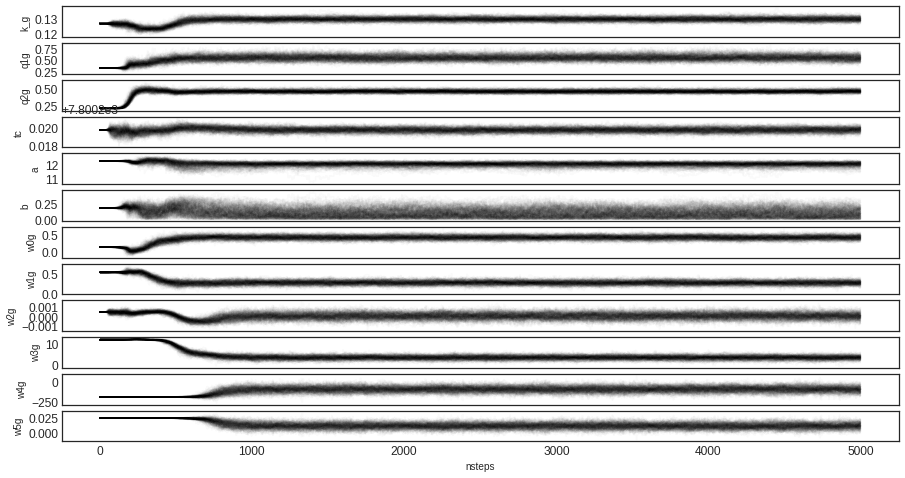

In [63]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_g)]
    
pl.xlabel('nsteps')

## Save results

In [64]:
import gzip

with gzip.GzipFile('step1_chain1.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1_lnp1.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

In [65]:
nsteps2 = 5000

sampler.reset()

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

5000it [22:17,  3.97it/s]


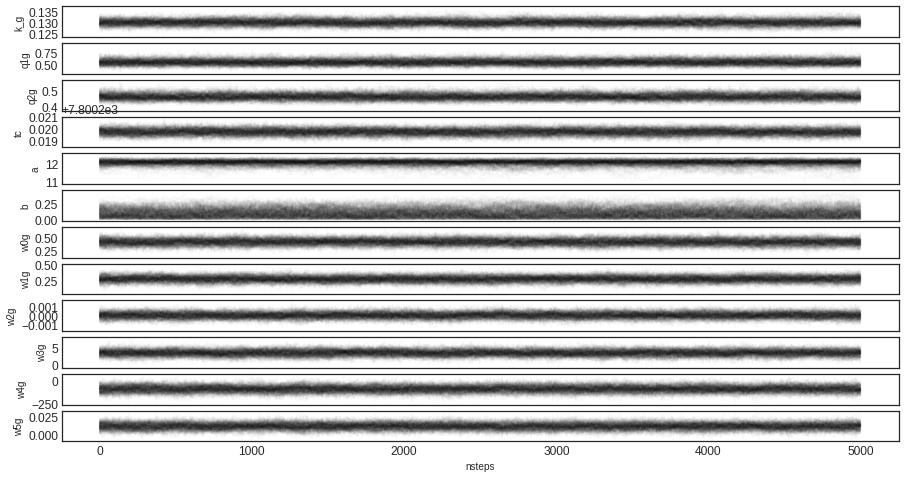

In [68]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_g)]
    
pl.xlabel('nsteps')

In [67]:
import gzip

with gzip.GzipFile('step1g_chain2.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1g_lnp2.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

### r-band (n=1)

In [69]:
import emcee

n=1

ndim = len(full_params)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 5000

#input to the model
args = [times[n], fluxes[n], _P, colors1[n], colors2[n], dxs[n], errs[n], ldp[n]]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

pos0 = []
#random numbers "around" the initial values
for i in range(nwalkers):
    #pick a random number
    rnum = 1e-8 * np.random.randn(ndim)
    #add to each initial value of parameter
    new_param_vector = np.array(full_params) +rnum
    #append
    pos0.append(new_param_vector)

In [70]:
from tqdm import tqdm

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

5000it [20:57,  4.24it/s]


In [71]:
chain = sampler.chain 
chain.shape

(192, 5000, 12)

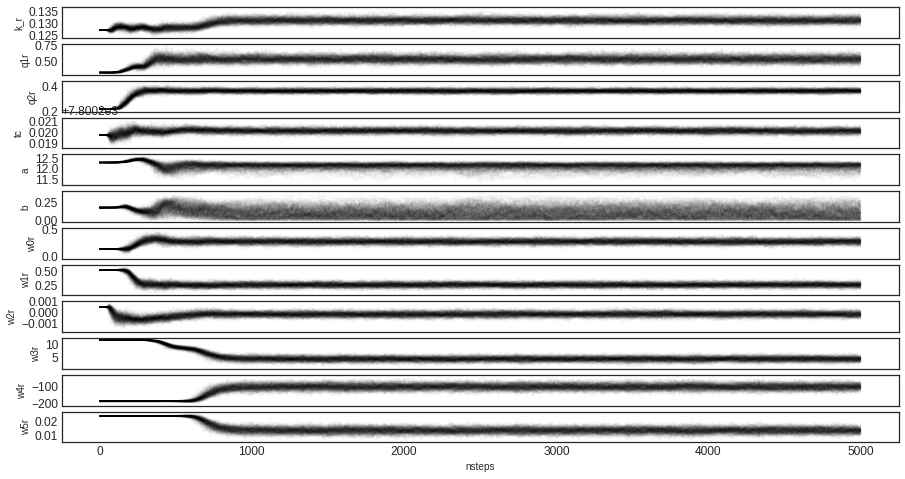

In [72]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_r)]
    
pl.xlabel('nsteps')

In [73]:
import gzip

with gzip.GzipFile('step1r_chain1.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1r_lnp1.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

In [74]:
nsteps2 = 5000

sampler.reset()

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

5000it [21:59,  3.55it/s]


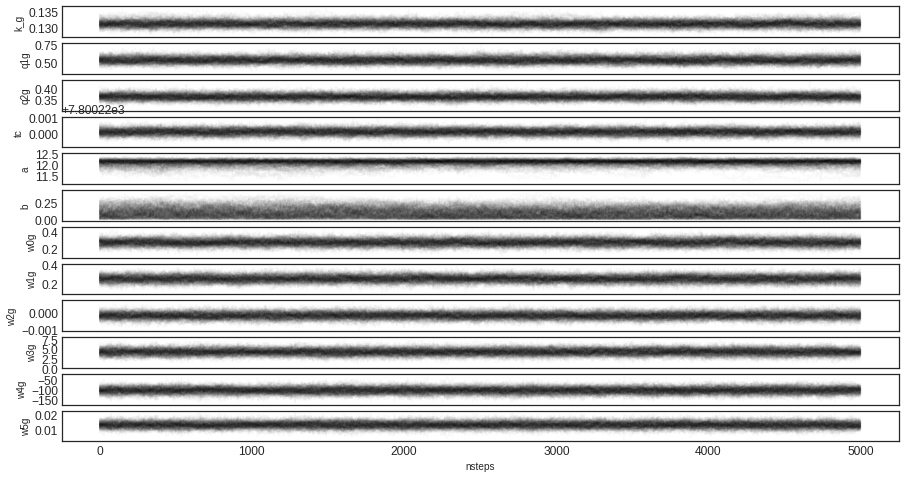

In [75]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_r)]
    
pl.xlabel('nsteps')

In [77]:
import gzip

with gzip.GzipFile('step1r_chain2.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1r_lnp2.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)chain2.shape, lnp2.shape

### z-band (n=2)

In [78]:
import emcee

n=2

ndim = len(full_params)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 5000

#input to the model
args = [times[n], fluxes[n], _P, colors1[n], colors2[n], dxs[n], errs[n], ldp[n]]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

pos0 = []
#random numbers "around" the initial values
for i in range(nwalkers):
    #pick a random number
    rnum = 1e-8 * np.random.randn(ndim)
    #add to each initial value of parameter
    new_param_vector = np.array(full_params) +rnum
    #append
    pos0.append(new_param_vector)

In [79]:
from tqdm import tqdm

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

237it [01:07,  3.91it/s]/home/prometheus/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/prometheus/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
5000it [21:43,  3.79it/s]


In [80]:
chain = sampler.chain 
chain.shape

(192, 5000, 12)

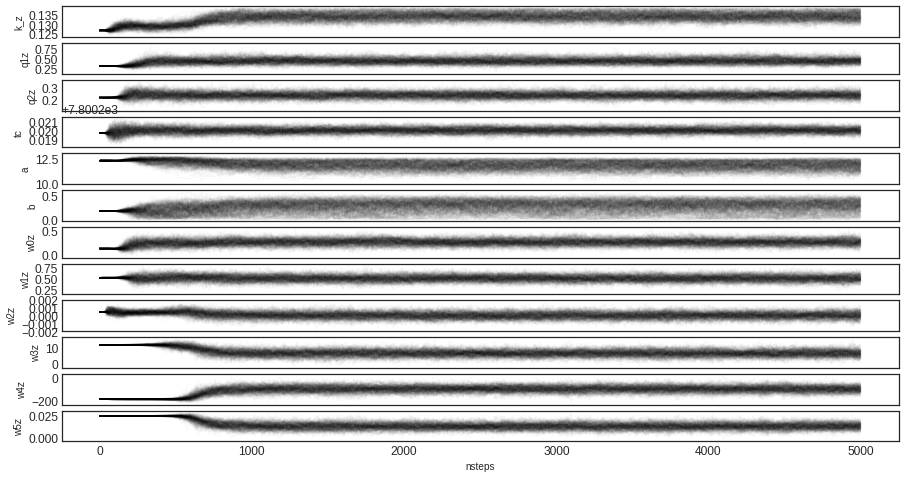

In [81]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_z)]
    
pl.xlabel('nsteps')

In [82]:
import gzip

with gzip.GzipFile('step1z_chain1.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1z_lnp1.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

In [83]:
nsteps2 = 5000

sampler.reset()

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

130it [00:32,  3.95it/s]/home/prometheus/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/prometheus/miniconda3/envs/astroconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
5000it [21:53,  3.67it/s]


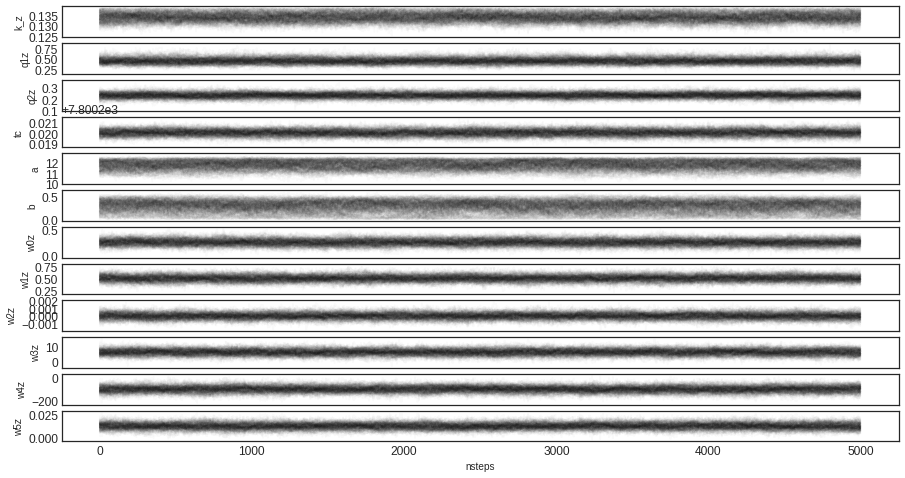

In [84]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(params_z)]
    
pl.xlabel('nsteps')

In [85]:
import gzip

with gzip.GzipFile('step1z_chain2.npy.gz', 'w') as g1:
    np.save(g1, sampler.chain)
    
with gzip.GzipFile('step1z_lnp2.npy.gz', 'w') as g2:
    np.save(g2, sampler.flatlnprobability)

# Analyzing chains

In [ ]:
nwalkers, nsteps, ndim = chain1.shape

fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain1.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [ ]:
nwalkers

In [ ]:
burn = 9000

fc = chain1[:,burn:,:].reshape(-1, chain1.shape[-1])
idx = np.argmax(lnp1[burn*nwalkers:])
pv =fc[idx]

In [ ]:
[(n,p) for n,p in zip(param_names,pv)]

## Convergence
* [Gelman-Rubin statistic]()

In [ ]:
def gelman_rubin(chains, verbose=False):
    assert chains.ndim == 3
    nn = chains.shape[1]
    mean_j = chains.mean(axis=1)
    var_j = chains.var(axis=1)
    B = nn * mean_j.var(axis=0)
    W = var_j.mean(axis=0)
    R2 = ( W*(nn-1)/nn + B/nn ) / W
    return np.sqrt(R2)

In [ ]:
gelman_rubin(chain1)

In [ ]:
def chisq(resid, sig, ndata=None, nparams=None, reduced=False):
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return np.sqrt(sum((resid / sig)**2)/ (dof))
    else:
        return sum((resid / sig)**2)

In [ ]:
np.array(param_names).T

In [ ]:
col1=[0,9,10,3,4,5,6,15,16,17,18,19,20]
col2=[1,11,12,3,4,5,7,21,22,23,24,25,26]
col3=[2,13,14,3,4,5,8,27,28,29,30,31,32]

In [ ]:
times    = []
fluxes   = []
colors1  = []
colors2  = []
errs     = []
dxs      = []
#dys      =[]
#airmasses= []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    colors1.append(df['color1'])
    colors2.append(df['color2'])
    errs.append(df['err(r=11.0)'])    
    dxs.append(df['dx(pix)'])    

In [ ]:
t1,t2,t3                   = times
f1,f2,f3                   = fluxes
color1g,color1r,color1z    = colors1
color2g,color2r,color2z    = colors2
dx1,dx2,dx3                = dxs
err1,err2,err3             = errs

In [ ]:
len(fc[0])

In [ ]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

mod_sys = {}
sys = {}
mod = {}

#params varies per band
for b,t,f,c1,c2,dx,e,col in zip(bands,
                              [t1,t2,t3],
                              [f1,f2,f3],
                              [color1g,color1r,color1z],
                              [color2g,color2r,color2z],
                              [dx1,dx2,dx3],
                              [err1,err2,err3],
                              [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [c1, c2, dx, e]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
            
        mod_sys[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_full=True)

In [ ]:
param_names='k_g,k_r,k_z,tc,a,b,lsj1,lsj2,lsj3,q1g,q2g,q1r,q2r,q1z,q2z,w0g,w1g,w2g,w3g,w4g,w5g,w0r,w1r,w2r,w3r,w4r,w5r,w0z,w1z,w2z,w3z,w4z,w5z'.split(',')

In [ ]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(times[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(times[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(times[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-44b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

In [ ]:
import pandas as pd
pd.set_option('display.precision',4)

n=-18
df = pd.DataFrame(data=fc[:,:n].copy(), columns=param_names[:n])
# df['e'] *= 1e6
# df['k'] = sqrt(df.k2)
# df['u'] = 2*sqrt(df.q1)*df.q2
# df['v'] = sqrt(df.q1)*(1-2*df.q2)
# df = df.drop('k2', axis=1)
df.describe()

In [ ]:
import seaborn as sb
sb.set_style('white')

fig = pl.figure(figsize=(15,15))

n=-18
cols = df.columns#[:n]
corr = df[cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sb.heatmap(corr, mask=mask, annot=True, square=True)


In [ ]:
import corner


fig = corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig = corner.corner(fc[:,9:15], labels=param_names[9:15], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig = corner.corner(fc[:,6:9], labels=param_names[6:9], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
fig = corner.corner(fc[:,:-1], labels=param_names[:-1], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [ ]:
def chisq(resid, sig, ndata=None, nparams=None, reduced=False):
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return np.sqrt(sum((resid / sig)**2)/ (dof))
    else:
        return sum((resid / sig)**2)

In [ ]:
b = 'g'
resids[b] = fluxes[0] - mod_best[b] - sys_best[b]

In [ ]:
param_names[9:15]

In [ ]:
pv[6]

In [ ]:
sigma1 = np.sqrt(np.exp(pv[6])**2+err1**2)

In [ ]:
chisq(resids[b], sigma1, ndata=len(mod_best[b]), nparams=len(pv), reduced=True)

In [ ]:
resids = {}
chi2s = {}

n=0
for b,num,err in zip(bands,[6,7,8],errs):
    resids[b] = fluxes[n] - mod_best[b] - sys_best[b]
    sigma = np.sqrt(np.exp(pv[num])**2+err**2)
    chi2s[b] = chisq(resids[b], sigma, ndata=len(mod_best[b]), nparams=len(pv), reduced=True)
    n+=1

In [ ]:
chi2s